#  Herculens point sources

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', interpolation='none')

# Basic imports
import numpy as np
from functools import partial

# JAX-related imports
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.MassModel.mass_model import MassModel
from herculens.LightModel.light_model import LightModel
from herculens.PointSourceModel.point_source_model import PointSourceModel
from herculens.LensImage.lens_image import LensImage

## Pixel grid

In [2]:
npix = 100  # number of pixels per side
pix_size = 5. / npix  # angular pixel size [arcsec]
plane_half_size = npix * pix_size / 2.  # half image angular extent per side [arcsec]
ra_at_xy_0 = dec_at_xy_0 = -plane_half_size + pix_size / 2  # angular coordinates of the pixel (0, 0)
transform_pix2angle = pix_size * np.eye(2)  # transformation matrix between pixel and angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_size} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.05 arcsec
x range    : (-2.475, 2.475) arcsec
y range    : (-2.475, 2.475) arcsec


## Mass model

In [3]:
mass_model = MassModel(['SIE', 'SHEAR'])
kwargs_sie = {'theta_E': 1.4, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.02, 'gamma2': 0.08}
kwargs_lens = [kwargs_sie, kwargs_shear]

## Source light model

In [4]:
# source_model = LightModel(['GAUSSIAN'])
# kwargs_source = [{'amp': 1.0, 'sigma': 0.005, 'center_x': 0.075, 'center_y': -0.05}]
source_model = LightModel(['PIXELATED'])
pixels = np.zeros((npix, npix))
beta_x, beta_y = 0.075, -0.05
# beta_x, beta_y = 0.075, -0.15
i, j = pixel_grid.map_coord2pix(beta_x, beta_y)
pixels[int(j), int(i)] = 1.
kwargs_source = [{'pixels': pixels}]

## PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1}
# kwargs_psf = {'psf_type': 'NONE'}
psf = PSF(**kwargs_psf)

# Point Source

In [6]:
# lensEquationSolver = LensEquationSolver(lens_model_class)
# x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
#                                                       min_distance=deltaPix, search_window=numPix * deltaPix)
# # compute lensing magnification at image positions
# mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
# mag = np.abs(mag)  # ignore the sign of the magnification

# # perturb observed magnification due to e.g. micro-lensing
# mag_pert = np.random.normal(mag, 0.5, len(mag))
# point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
# kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
#                            'point_amp': point_amp}]  # quasar point source position in the image plane 
#                                                      # and intrinsic brightness

# # note: the relative magnification of point sources is not used as 
# #       constraints in the fitting in the default settings of lenstronomy.
# # you can set this constraint with the keyword 'fixed_magnification_list' (see next block). 
# # The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
# point_source_list = ['LENSED_POSITION']
# point_source = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

# ps_model = PointSourceModel(['IMAGE_POSITIONS', 'SOURCE_POSITION'], mass_model)
# kwargs_ps1 = {'ra': 1.5, 'dec': 0.7, 'amp': 1}
# # kwargs_ps1 = {'ra': [1.5, 0.8, -0.5], 'dec': [0.7, -1.3, 1.7], 'amp': [1., 1., 1.]}
# kwargs_ps2 = {'ra': 0.4, 'dec': 0.9, 'amp': 1.}
# kwargs_ps = [kwargs_ps1, kwargs_ps2]
# ps_model.source_positions(kwargs_ps, kwargs_lens)


point_source_model = PointSourceModel(['IMAGE_POSITIONS'], mass_model)
kwargs_point_source = [{'ra': [1.5, 0.8, -0.5], 'dec': [0.7, -1.3, 1.7], 'amp': [1., 2., 4.]}]

In [7]:
# point_source_model.image_positions(kwargs_point_source)

In [8]:
# point_source_model.source_positions(kwargs_point_source, kwargs_lens)

In [9]:
# point_source_model.image_amplitudes(kwargs_point_source)

In [10]:
# point_source_model.source_amplitudes(kwargs_point_source, kwargs_lens)

## Image model

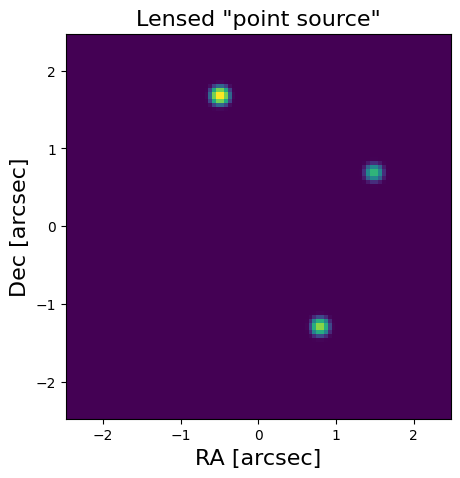

In [18]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 5}
lens_image = LensImage(pixel_grid, psf,
                       lens_mass_model_class=mass_model,
                       source_model_class=source_model,
                       point_source_model_class=point_source_model,
                       kwargs_numerics=kwargs_numerics)

kwargs_all = dict(kwargs_lens=kwargs_lens,
                  kwargs_source=kwargs_source,
                  kwargs_lens_light={},
                  kwargs_point_source=kwargs_point_source)

image = lens_image.model(**kwargs_all, source_add=False)
image += 0.01
log_image = np.log(image)

# visualize simulated products
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(log_image, origin='lower', extent=pixel_grid.extent)
ax.set_aspect('equal')
ax.set_title('Lensed "point source"', fontsize=16)
ax.set_xlabel('RA [arcsec]', fontsize=16)
ax.set_ylabel('Dec [arcsec]', fontsize=16);
# plt.savefig('/Users/austinpeel/Desktop/lensed_pt_src.png', format='png')

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float64[11,11])>with<DynamicJaxprTrace(level=0/1)>
This Tracer was created on line /Users/austinpeel/Software/StrongLensing/herculens/herculens/Util/util.py:56 (array2image)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

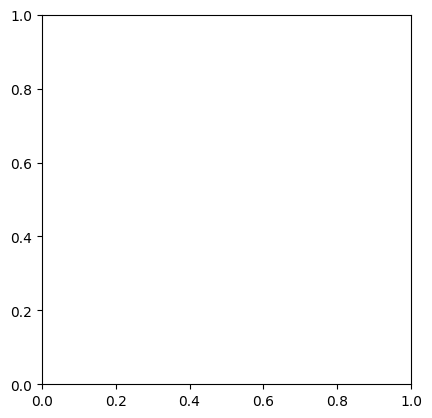

In [8]:
fig, ax = plt.subplots(1, 1)
psf_kernel = lens_image.ImageNumerics._psf.kernel_point_source
# img = lens_image.ImageNumerics._psf.kernel_point_source_supersampled(1)
ax.imshow(psf_kernel, origin='lower')

In [87]:
psf._pixel_size, psf.kernel_point_source.shape

(0.05, (11, 11))

In [ ]:
lens_image.ImageNumerics._psf._

In [171]:
from herculens.Util.jax_util import BilinearInterpolator, BicubicInterpolator

In [292]:
# x0, y0 = 1.732, 0.436
x0, y0 = 3 * delta, 5 * delta

In [293]:
delta = psf._pixel_size
nx, ny = psf.kernel_point_source.shape
xmin, xmax = -0.5 * nx * delta, 0.5 * nx * delta
ymin, ymax = -0.5 * ny * delta, 0.5 * ny * delta

In [294]:
xx = jnp.linspace(xmin, xmax, nx) + x0
yy = jnp.linspace(ymin, ymax, ny) + y0
x_kernel, y_kernel = jnp.meshgrid(xx, yy)

In [295]:
interp = BilinearInterpolator(xx, yy, psf.kernel_point_source, allow_extrapolation=False)
# interp = BicubicInterpolator(xx, yy, psf.kernel_point_source, allow_extrapolation=False)

In [296]:
x_coords, y_coords = pixel_grid.pixel_coordinates
ps_img = interp(x_coords, y_coords)
print(ps_img.sum())
ps_img /= ps_img.sum()

1.190082629356805


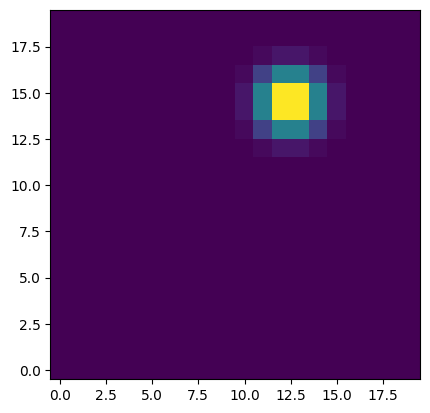

In [297]:
fig, ax = plt.subplots(1, 1)
ax.imshow(ps_img[40:60, 40:60], origin='lower')

(201, 201)


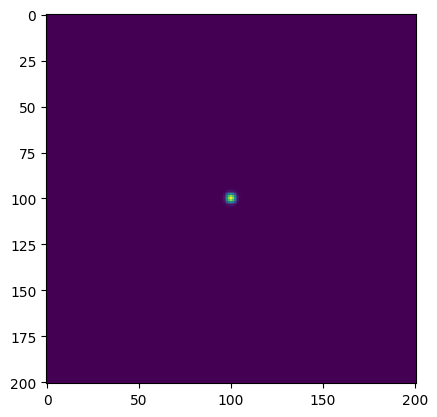

In [24]:
fig, ax = plt.subplots(1, 1)
img = lens_image.ImageNumerics._psf.kernel_point_source_supersampled(2)
ax.imshow(img)
print(img.shape)